# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [1]:
!pip -q install ./python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from collections import deque
import torch
import torch.optim as optim
from deep_rl import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
multiple_agents = True

if multiple_agents:
    # select this option to load version 2 (with 20 agents) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
else:
    # select this option to load version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [6]:
def run_steps_unity(agent):
    random_seed()
    config = agent.config
    while True:
        scores = agent.scores_deque
        if len(agent.scores_list) > 0:
            print('\rEpisode {}\tAverage Score Last {} Episodes: {:.2f}\tAvg. Score (All Agents) Last Episode: {:.2f}'.format(len(agent.scores_list), len(scores), np.mean(scores), agent.scores_list[-1]), end="")
        if len(agent.scores_list) > 0 and len(agent.scores_list) % 100 == 0:
            save_path = 'PPO-ReacherV2-checkpoint.bin'
            agent.save(save_path)
            print('\rEpisode {}\tAverage Score Last {} Episodes: {:.2f}'.format(len(agent.scores_list), len(scores),
                np.mean(scores)))
        if len(scores) and (np.mean(scores) >= 30.0):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(len(agent.scores_list)-100, np.mean(scores)))
            save_path = 'PPO-ReacherV2-solved.bin'
            agent.save(save_path)
            res = True, agent.scores_deque, agent.scores_list, save_path
            agent.close()
            return res
        if config.max_steps and agent.total_steps >= config.max_steps:
            print('\nMax episodes reached!\tFinal Average Score: {:.2f}'.format(np.mean(scores)))
            save_path = 'PPO-ReacherV2-max-steps.bin'
            agent.close()
            return False, None, None, None
        agent.step()

In [7]:
class BaseTaskUnity:
    def __init__(self):
        pass

    def reset(self):
        env_info = self.env.reset(train_mode=True)[brain_name]
        return np.array(env_info.vector_observations)

    def step(self, action):
        env_info = self.env.step(action)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        if np.any(dones):
            next_states = self.reset()
        return np.array(next_states), np.array(rewards), np.array(dones), None

    def seed(self, random_seed):
        pass

    
class ReacherV1(BaseTaskUnity):
    def __init__(self, name, log_dir=None):
        BaseTaskUnity.__init__(self)
        self.name = name
        self.env = env
        self.action_dim = brain.vector_action_space_size
        self.state_dim = brain.vector_observation_space_size

    def step(self, action):
        return BaseTaskUnity.step(self, np.clip(action, -1, 1))

In [8]:
def ppo_continuous_unity():
    config = Config()
    config.num_workers = num_agents
    # task_fn = lambda log_dir: Pendulum(log_dir=log_dir)
    # task_fn = lambda log_dir: Bullet('AntBulletEnv-v0', log_dir=log_dir)
    task_fn = lambda: ReacherV1('ReacherV1')
    config.task_fn = task_fn
    config.eval_env = task_fn()

    config.network_fn = lambda: GaussianActorCriticNet(
        config.state_dim, config.action_dim, actor_body=FCBody(config.state_dim),
        critic_body=FCBody(config.state_dim))
    config.optimizer_fn = lambda params: torch.optim.Adam(params, 3e-4, eps=1e-5)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 4096
    config.optimization_epochs = 10
    config.num_mini_batches = 256
    config.ppo_ratio_clip = 0.2
    config.log_interval = 2048
    config.max_steps = 2e7
    config.logger = get_logger()
    return run_steps_unity(PPOAgent(config))

In [9]:
success, avg_score, scores_list, path = ppo_continuous_unity()

Episode 200	Average Score Last 100 Episodes: 28.99	Avg. Score (All Agents) Last Episode: 36.59
Episode 208	Average Score Last 100 Episodes: 30.61	Avg. Score (All Agents) Last Episode: 36.55
Environment solved in 208 episodes!	Average Score: 30.61


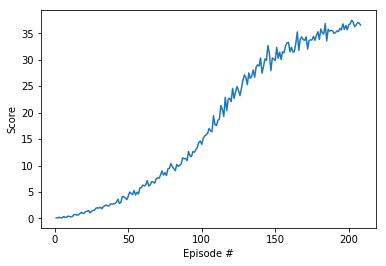

In [10]:
if success:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_list)+1), scores_list)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [18]:
from deep_rl.network.network_heads import GaussianActorCriticNet
from deep_rl.network.network_bodies import FCBody, DummyBody
import torch
from torch.autograd import Variable
from torchviz import make_dot
import numpy as np

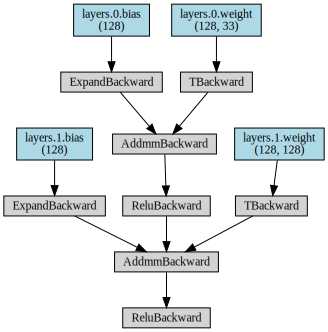

In [15]:
model = FCBody(33)

x = Variable(torch.randn(33)).unsqueeze(0)
model.eval()
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

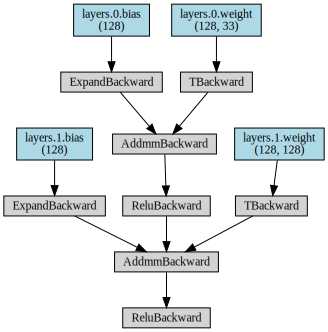

In [16]:
critic_model = FCBody(33)

x = Variable(torch.randn(33)).unsqueeze(0)
model.eval()
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))